In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from functions import *
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE

In [2]:
socio = pd.read_feather('BF_Dados_Socio_Economicos.feather')
socio = socio.drop_duplicates('identificação')
cont = pd.read_feather('BF_Dados_Contratos.feather')
cont = cont.loc[cont['CONTRATO'] > 40000]
df = cont.join(socio.set_index('identificação'),on = 'IDENTIFICAÇÃO')
df = df.loc[~df['atividade'].isna()]
df['DEFAULT'] = df['ATRASO_DIAS'] > 90
df.loc[df['numero_de_pessoas_na_casa'] > 10,'numero_de_pessoas_na_casa'] = 10
serie = df['numero_de_pessoas_na_casa'].dropna()
df.loc[df['numero_de_pessoas_na_casa'].isna(),'numero_de_pessoas_na_casa'] = np.random.normal(serie.mean(),serie.std(),df['numero_de_pessoas_na_casa'].isna().sum())
df['numero_de_pessoas_na_casa'] = df['numero_de_pessoas_na_casa'].apply(lambda x: round(abs(x)))
df = df.dropna().sample(frac = 1).reset_index(drop = True)
to_drop = ['SITUACAO','QUANTIDADE_PAGAS','ATRASO_DIAS','ATRASO_MAXIMO','RENEGOCIADO','BAIRRO','CONTRATO','IDENTIFICAÇÃO','CEP','melhor_data_vencimento','QUANTIDADE_PARCELAS','VALOR_EMPRESTIMO','PRESTACAO','valor_solicitado','melhor_valor_parcela']
df = df.drop(to_drop,axis = 1)
df = numerize_dummie(df)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('DEFAULT',axis = 1).values,df['DEFAULT'].values,test_size = 0.25)
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

In [9]:
lr = LogisticRegression(C=0.1)
xgb_scale = XGBRegressor(scale_pos_weight = 5)

clf_list = [
    (lr, "Logistic"),
    (xgb_scale, "XGBoost Scale"),
]

ValueError: 'estimator' should be a fitted classifier.

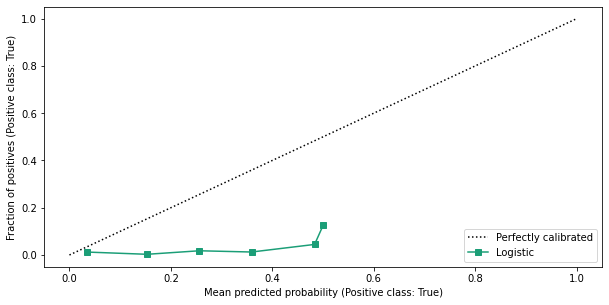

In [10]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(x_smote, y_smote)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()